In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import configs

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
def recalc_val(save_path):
    net_config_path = save_path + 'net_configs.p'
    state_dict_path = save_path + 'model.pt'
    datasets = [ 
        inputs.Sim1DWalk(num_steps=500, left_right_stay_prob=[5,1,1], num_states=64),
        inputs.Sim2DWalk(num_steps=500, num_states=64),
        inputs.Sim2DLevyFlight(num_steps=500, walls=7)
        ]
    with open(net_config_path, 'rb') as f:
        net_configs = pickle.load(f)
    net = STDP_SR(
        num_states=64, gamma=net_configs['gamma'],
        ca3_kwargs=net_configs['ca3_kwargs']
        )
    net.load_state_dict(torch.load(state_dict_path))
    net.ca3.set_differentiability(False)
    
    criterion = nn.MSELoss(reduction='none')
    errs = []
    with torch.no_grad():
        for dset in datasets:
            dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
            dg_modes = torch.from_numpy(dset.dg_modes.T).float().to(device).unsqueeze(1)
            _, outputs = net(dg_inputs, dg_modes, reset=True)
            est_T = net.ca3.get_T().detach().numpy()
            real_T = net.ca3.get_real_T()
            err = np.mean(np.abs(est_T - real_T))
            errs.append(err)
    return np.mean(err)

In [3]:
with open("../trained_models_copy/01_tau_gridsearch/results.p", 'rb') as f:
    results = pickle.load(f)

In [4]:
param_regex = 'pos(.*)_neg(.*)'
gridsearch_dir = "../trained_models_copy/01_tau_gridsearch/"
tau_neg_axes = []
tau_pos_axes = []
vals = []
A_poses = []
A_negs = []
results = {
    'tau_neg_axes': tau_neg_axes,
    'tau_pos_axes': tau_pos_axes,
    'vals': vals,
    'A_poses': A_poses,
    'A_negs': A_negs
}
for d in os.listdir(gridsearch_dir):
    param_match = re.search(param_regex, d)
    if param_match is None: continue
    tau_neg_axes.append(float(param_match.group(1)))
    tau_pos_axes.append(float(param_match.group(2)))

#     try:
#         val = recalc_val(gridsearch_dir + d + '/')
#     except:
#         val = np.nan
    
    val = np.nan
    A_pos = np.nan
    A_neg = np.nan
    for file in os.listdir(gridsearch_dir + d):
        if 'tfevents' not in file: continue
        tfevents_file = gridsearch_dir + d + '/' + file
        event_acc = EventAccumulator(tfevents_file)
        event_acc.Reload()
        val = event_acc.Scalars('loss_train')[-1].value
        model_file = gridsearch_dir + d + '/' + 'model.pt'
        state_dict = torch.load(model_file)
        A_pos = abs(state_dict['ca3.A_pos'])
        A_neg = abs(state_dict['ca3.A_neg'])
        break
    vals.append(val)
    A_poses.append(A_pos)
    A_negs.append(A_neg)

In [5]:
xs = np.array(results['tau_neg_axes'])
ys = np.array(results['tau_pos_axes'])
xs = np.sort(np.unique(xs))
ys = np.sort(np.unique(ys))

# Plot just errors

In [6]:
mat = np.zeros((xs.size, ys.size))*np.nan
for tau_neg_ax, tau_pos_ax, val in zip(
    results['tau_neg_axes'], results['tau_pos_axes'], results['vals']
    ):
    x_idx = np.argwhere(xs == tau_neg_ax)[0,0]
    y_idx = np.argwhere(ys == tau_pos_ax)[0,0]
    mat[x_idx][y_idx] = val

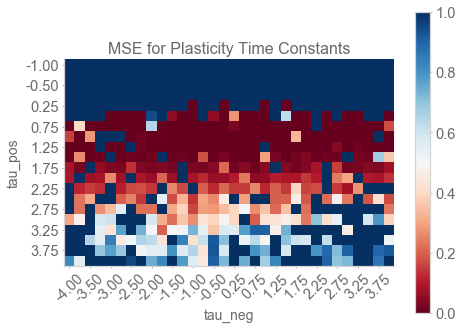

In [7]:
plt.figure(figsize=(7,5))
plt.imshow(mat, cmap="RdBu", vmax=1.0)
plt.yticks(
    np.arange(xs.size)[::2],
    [f'{x:.2f}' for x in xs][::2]
    )
plt.xticks(
    np.arange(ys.size)[::2], [f'{y:.2f}' for y in ys][::2],
    rotation=45
    )
plt.xlabel('tau_neg', fontsize=14)
plt.ylabel('tau_pos', fontsize=14)
plt.colorbar()
plt.title("MSE for Plasticity Time Constants", fontsize=16)
plt.tight_layout()
plt.savefig("tau_grid_mse.png", dpi=300)
plt.show()

# Plot errors where scaling factors is sufficient

In [8]:
Aneg_mat = np.zeros((xs.size, ys.size))*np.nan
for tau_neg_ax, tau_pos_ax, A_neg in zip(
    results['tau_neg_axes'], results['tau_pos_axes'], results['A_negs']
    ):
    x_idx = np.argwhere(xs == tau_neg_ax)[0,0]
    y_idx = np.argwhere(ys == tau_pos_ax)[0,0]
    Aneg_mat[x_idx][y_idx] = A_neg*10*np.exp(-1/abs(tau_neg_ax))

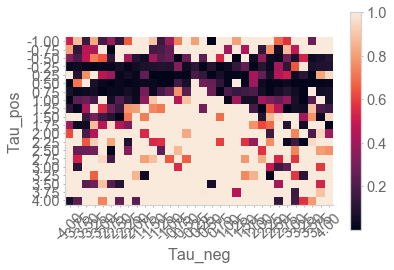

In [9]:
plt.figure()
plt.imshow(Aneg_mat, vmax=1)
plt.yticks(np.arange(xs.size), [f'{x:.2f}' for x in xs])
plt.xticks(
    np.arange(ys.size), [f'{y:.2f}' for y in ys],
    rotation=45
    )
plt.xlabel('Tau_neg')
plt.ylabel('Tau_pos')
plt.colorbar()
plt.show()

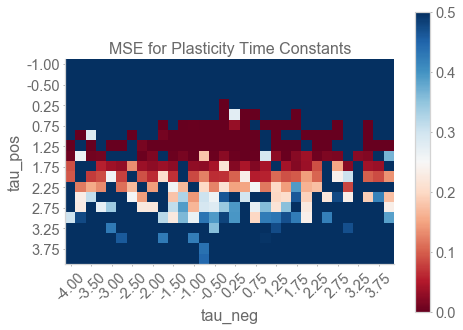

In [12]:
mat = np.zeros((xs.size, ys.size))*np.nan
for tau_neg_ax, tau_pos_ax, val in zip(
    results['tau_neg_axes'], results['tau_pos_axes'], results['vals']
    ):
    x_idx = np.argwhere(xs == tau_neg_ax)[0,0]
    y_idx = np.argwhere(ys == tau_pos_ax)[0,0]
    mat[x_idx][y_idx] = val
    
plt.figure(figsize=(7,5))
mat[Aneg_mat<0.1] = 1
plt.imshow(mat, cmap="RdBu", vmax=0.5)
plt.yticks(
    np.arange(xs.size)[::2],
    [f'{x:.2f}' for x in xs][::2]
    )
plt.xticks(
    np.arange(ys.size)[::2], [f'{y:.2f}' for y in ys][::2],
    rotation=45
    )
plt.xlabel('tau_neg')
plt.ylabel('tau_pos')
plt.colorbar()
plt.title("MSE for Plasticity Time Constants")
plt.tight_layout()
plt.savefig("tau_grid_mse_zeroed.png", dpi=300)
plt.show()